# FACEBOOK DATA FROM YAHOO FINANCE

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("packtpub-notebooks/packtpub-src/csv/FB2012-2019.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-29,31.480000,31.690001,28.650000,28.840000,28.840000,78063400
1,2012-05-30,28.700001,29.549999,27.860001,28.190001,28.190001,57267900
2,2012-05-31,28.549999,29.670000,26.830000,29.600000,29.600000,111639200
3,2012-06-01,28.889999,29.150000,27.389999,27.719999,27.719999,41855500
4,2012-06-04,27.200001,27.650000,26.440001,26.900000,26.900000,35230300


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1755,2019-05-21,184.570007,185.699997,183.889999,184.820007,184.820007,7502800
1756,2019-05-22,184.729996,186.740005,183.610001,185.320007,185.320007,9213800
1757,2019-05-23,182.419998,183.899994,179.669998,180.869995,180.869995,12768800
1758,2019-05-24,182.330002,183.630005,180.830002,181.059998,181.059998,8807700
1759,2019-05-28,181.539993,184.710007,181.449997,184.309998,184.309998,14843300


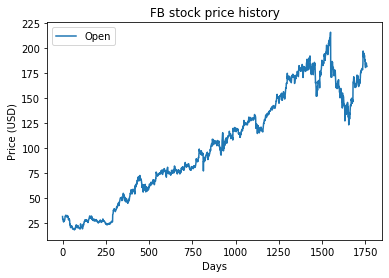

In [5]:
plt.figure()
plt.title("FB stock price history")
plt.plot(df['Open'])
#plt.plot(df["Close"])
#plt.plot(df["High"])
#plt.plot(df["Low"])
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open', 'Close', 'High', 'Low'], loc='upper left')
plt.show()

# Computing moving average, last 140 days

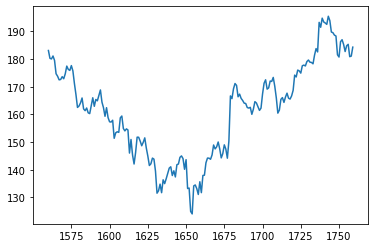

In [6]:
real_price_last200 = df['Close'][-200:]
plt.plot(real_price_last200[-200:])

In [7]:
def computes_moving_average(input_vector, window_length):
    start = 0
    moving_average = []
    for i in range(len(input_vector)-window_length + 1):
        current_window = input_vector[i:i+window_length-1]
        average = sum(current_window)/window_length
        moving_average.append(average)
    return moving_average

In [8]:
moving_average = computes_moving_average(real_price_last200, 60)

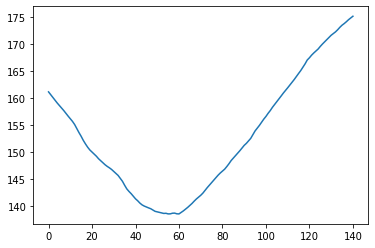

In [9]:
plt.plot(moving_average)

# _________________________________

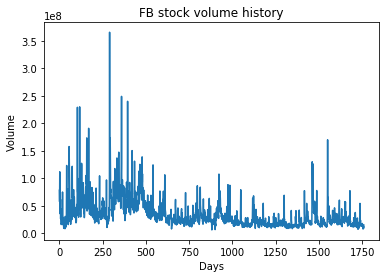

In [10]:
plt.figure()
plt.plot(df['Volume'])
plt.title('FB stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [11]:
print('Checking if any null values are present\n', df.isna().sum())

Checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


### Normalizing the data
* Split the data into train, test
* Normalize
* Covert the DataFrame to ndarray

In [12]:
#! pip install keras

In [13]:
#! pip install np_utils

In [14]:
#! pip install tensorflow

In [35]:
#! pip install numpy --upgrade --user

In [20]:
#from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


#print('Checking GPU available', K.tensorflow_backend._get_available_gpus())


In [21]:
TIME_STEPS = 60
BATCH_SIZE = 20

In [22]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}

In [23]:

train_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print('Train and test set', len(df_train), len(df_test))

#scale the feature MinMax, build array
x = df_train.loc[:, train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:, train_cols])

Train and test set 1408 352


In [27]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total nb of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    
    print('length of time-series i/o', x.shape, y.shape)
    return x, y

In [28]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that is divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0] % batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [29]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE) 
# training

x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE), 2) # validation and test
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE), 2)

length of time-series i/o (1348, 60, 5) (1348,)
length of time-series i/o (292, 60, 5) (292,)


# XGBOOST

In [40]:
import xgboost as xgb

In [59]:
y_t.shape, y_temp.shape

((1340,), (292,))

In [ ]:
x_t = x_t[:, :, 0]
x_temp = x_temp[:, :, 0]

In [41]:
x_t.shape

(1340, 60)

In [50]:
# read in data
dtrain = xgb.DMatrix(x_t,label=y_t)

In [43]:
dtest = xgb.DMatrix(x_temp)

In [54]:
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'reg:squarederror' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)

In [55]:
# make prediction
preds = bst.predict(dtest)

In [61]:
from sklearn.metrics import mean_squared_error as mse

In [63]:
mse(y_temp, preds)

0.009442702531150347

# LSTM

In [ ]:
from keras import losses
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers
from keras import backend as K
from keras.callbacks import EarlyStopping

In [20]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, time_steps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                       dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                       kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20, activation='relu'))
    lstm_model.add(Dense(1, activation='linear'))
    optimizer = optimizers.RMSprop(lr=params['lr'])
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    # lstm_model.compile(loss=losses.mean_squarred_error, optimizer=optimizer)
    return lstm_model

In [21]:
"""
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=40, min_delta=0.0001)
"""

In [22]:
"""
model = create_model()

#csv_logger = CSVLogger()

history = model.fit(x_t, y_t, epochs=params['epochs'], verbose=2, batch_size=BATCH_SIZE,
                   shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE), 
                                                   trim_dataset(y_val, BATCH_SIZE)))
"""

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1340 samples, validate on 140 samples
Epoch 1/300
 - 9s - loss: 0.0098 - val_loss: 0.0080
Epoch 2/300
 - 6s - loss: 0.0078 - val_loss: 0.0131
Epoch 3/300
 - 5s - loss: 0.0067 - val_loss: 0.0063
Epoch 4/300
 - 6s - loss: 0.0056 - val_loss: 0.0103
Epoch 5/300
 - 6s - loss: 0.0051 - val_loss: 0.0067
Epoch 6/300
 - 6s - loss: 0.0041 - val_loss: 0.0039
Epoch 7/300
 - 6s - loss: 0.0044 - val_loss: 0.0069
Epoch 8/300
 - 6s - loss: 0.0041 - val_loss: 0.0084
Epoch 9/300
 - 6s - loss: 0.0042 - val_loss: 0.0037
Epoch 10/300
 - 6s - loss: 0.0040 - val_loss: 0.0037
Epoch 11/300
 - 6s - loss: 0.0038 - val_loss: 0.0068
Epoch 12/300
 - 6s - loss: 0.0038 - val_loss: 0.0064
Epoch 13/300
 - 5s - loss: 0.0037 - val_loss: 0.0087
Epoch 14/300
 - 5s - loss: 0.0034 - va

Epoch 137/300
 - 5s - loss: 0.0013 - val_loss: 0.0025
Epoch 138/300
 - 5s - loss: 0.0014 - val_loss: 0.0040
Epoch 139/300
 - 5s - loss: 0.0013 - val_loss: 0.0060
Epoch 140/300
 - 5s - loss: 0.0013 - val_loss: 0.0032
Epoch 141/300
 - 5s - loss: 0.0012 - val_loss: 0.0041
Epoch 142/300
 - 5s - loss: 0.0013 - val_loss: 0.0048
Epoch 143/300
 - 5s - loss: 0.0012 - val_loss: 0.0060
Epoch 144/300
 - 5s - loss: 0.0013 - val_loss: 0.0025
Epoch 145/300
 - 5s - loss: 0.0013 - val_loss: 0.0051
Epoch 146/300
 - 5s - loss: 0.0012 - val_loss: 0.0038
Epoch 147/300
 - 5s - loss: 0.0012 - val_loss: 0.0043
Epoch 148/300
 - 5s - loss: 0.0012 - val_loss: 0.0042
Epoch 149/300
 - 5s - loss: 0.0011 - val_loss: 0.0042
Epoch 150/300
 - 5s - loss: 0.0012 - val_loss: 0.0032
Epoch 151/300
 - 5s - loss: 0.0013 - val_loss: 0.0058
Epoch 152/300
 - 5s - loss: 0.0012 - val_loss: 0.0048
Epoch 153/300
 - 5s - loss: 0.0012 - val_loss: 0.0073
Epoch 154/300
 - 5s - loss: 0.0012 - val_loss: 0.0050
Epoch 155/300
 - 5s - loss: 

Epoch 285/300
 - 5s - loss: 8.4997e-04 - val_loss: 0.0021
Epoch 286/300
 - 5s - loss: 9.4071e-04 - val_loss: 0.0053
Epoch 287/300
 - 5s - loss: 9.8036e-04 - val_loss: 0.0035
Epoch 288/300
 - 5s - loss: 9.5272e-04 - val_loss: 0.0022
Epoch 289/300
 - 5s - loss: 9.4515e-04 - val_loss: 0.0029
Epoch 290/300
 - 5s - loss: 9.0881e-04 - val_loss: 0.0026
Epoch 291/300
 - 5s - loss: 8.7857e-04 - val_loss: 0.0026
Epoch 292/300
 - 5s - loss: 9.9003e-04 - val_loss: 0.0022
Epoch 293/300
 - 5s - loss: 9.1522e-04 - val_loss: 0.0061
Epoch 294/300
 - 5s - loss: 9.0597e-04 - val_loss: 0.0032
Epoch 295/300
 - 5s - loss: 9.3274e-04 - val_loss: 0.0021
Epoch 296/300
 - 5s - loss: 9.5214e-04 - val_loss: 0.0037
Epoch 297/300
 - 5s - loss: 8.8673e-04 - val_loss: 0.0041
Epoch 298/300
 - 5s - loss: 9.4184e-04 - val_loss: 0.0032
Epoch 299/300
 - 5s - loss: 9.0845e-04 - val_loss: 0.0048
Epoch 300/300
 - 5s - loss: 8.5980e-04 - val_loss: 0.0021


In [23]:
x_t.shape

(1340, 60, 5)

In [24]:
# save model
import pickle

#filename = 'lstm_model_300.sav'
#pickle.dump(model, open(filename, 'wb'))

In [48]:
# load the model
import pickle
filename = 'lstm_model_300.sav'
loaded_model = pickle.load(open(filename, 'rb'))
model = loaded_model


In [45]:
print(history.history.keys())
print(history.history['val_loss'])

NameError: name 'history' is not defined

In [ ]:
plt.figure()
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['Test', 'Train'])
plt.xlabel('Epoch')
plt.ylabel('Model loss')

In [46]:
# plot the predicted vs real price

LSTM

In [49]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error", error, y_pred.shape, y_test_t.shape)

y_pred_orig = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_pred)
y_test_t_orig = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_test_t)

Error 0.002056557195722951 (140,) (140,)


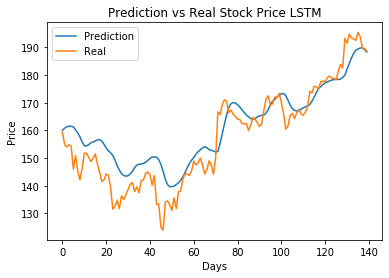

In [50]:
plt.figure()
plt.plot(y_pred_orig)
plt.plot(y_test_t_orig)
plt.title('Prediction vs Real Stock Price LSTM')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

plotting moving average

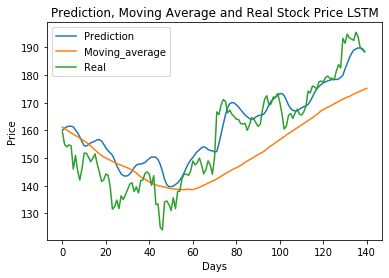

In [56]:
plt.figure()
plt.plot(y_pred_orig)
plt.plot(moving_average)
plt.plot(y_test_t_orig)
plt.title('Prediction, Moving Average and Real Stock Price LSTM')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Moving_average', 'Real'], loc='upper left')
plt.show()

# Exponentially weighted moving average

In [66]:
type(real_price_last200)

pandas.core.series.Series

In [79]:
#taking -200, -60 days
some_weird_days = real_price_last200[60:]

In [80]:
ewma = some_weird_days.ewm(span=60).mean()

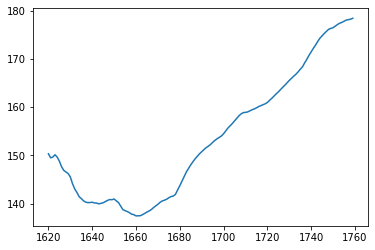

In [81]:
plt.plot(ewma)

In [82]:
ewma.shape

(140,)

In [83]:
y_pred_orig.shape

(140,)

In [85]:
print(ewma)

1620    150.350006
1621    149.501083
1622    149.652293
1623    150.145447
1624    149.659520
1625    148.809572
1626    147.665953
1627    146.894786
1628    146.556448
1629    146.243437
1630    145.526418
1631    144.136559
1632    143.045169
1633    142.322053
1634    141.439504
1635    141.038217
1636    140.580596
1637    140.302980
1638    140.189571
1639    140.217899
1640    140.274694
1641    140.126779
1642    140.096362
1643    139.937021
1644    140.047946
1645    140.162879
1646    140.402490
1647    140.651448
1648    140.831790
1649    140.798504
           ...    
1730    165.590674
1731    166.036724
1732    166.464425
1733    166.860683
1734    167.349261
1735    167.899485
1736    168.390754
1737    169.222415
1738    169.966587
1739    170.795314
1740    171.549813
1741    172.266354
1742    172.941928
1743    173.692581
1744    174.364883
1745    174.877655
1746    175.365460
1747    175.807213
1748    176.223774
1749    176.400393
1750    176.544171
1751    176.

In [89]:
ewma = ewma.to_numpy()

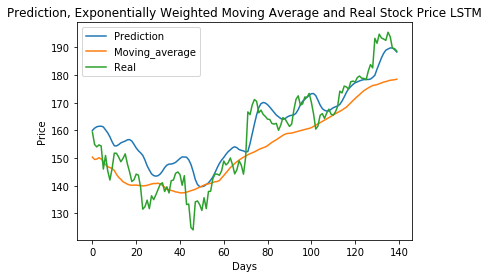

In [91]:
plt.figure()
plt.plot(y_pred_orig)
plt.plot(ewma)
plt.plot(y_test_t_orig)
plt.title('Prediction, Exponentially Weighted Moving Average and Real Stock Price LSTM')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Moving_average', 'Real'], loc='upper left')
plt.show()

In [31]:
# do gridsearch, put logging into
# what overfit would mean here?
# read lstm AK
# how to appreciate how good is the prediction?

# sentiment analysis for stock prediction ? X

# ! when u use lstm, y is the close price of that they
# on another model I think you kept the close price of that they

In [32]:
print(type(y_test_t_orig))
print(y_test_t_orig.shape)

<class 'numpy.ndarray'>
(140,)


# STRATEGY


    http://cs229.stanford.edu/proj2017/final-reports/5241098.pdf

We consider a simple algorithmic trading strategy based
on the prediction by the model. At day t, an investor buys
one share of INTC stock if the predicted price is higher
than the current actual adjusted closing price. Otherwise,
he or she sells one share of INTC stock. The strategy st
can be described as:
st =
(
+1 if yˆt+1 > yt
−1 if yˆt+1 ≤ yt

In [33]:
y_pred # prediction
pass

In [34]:
x_test_t # window
pass

In [35]:
# x_t : train data
# x_val: validation data
# x_test_t: test data

TODO
1. get data OK
2. write trading algorithm (function of the prediction) OK
3. compute returns

4. compute sharpe ratio of the strategy

In [36]:
y_pred_orig # predicted data
pass

In [37]:
y_test_t_orig # real data
pass

In [38]:
predicted_data = y_pred_orig
real_data = y_test_t_orig

In [39]:
len(predicted_data) == len(real_data)

True

In [40]:
assert len(predicted_data) == len(real_data)
type(predicted_data), type(predicted_data[0])

(numpy.ndarray, numpy.float32)

In [41]:
class strategy():
    def __init__(self):
        self.in = 0
    
    def take_action(self, today_real_price, tomorrow_forcasted_price):
        """
         At day t, an investor buys one share of INTC stock if the predicted price 
         is higher than the current actual adjusted closing price.
         Otherwise, he or she sells one share of INTC stock"""
        if tomorrow_forcasted_price > today_real_price:
            self.stocks += 1
        else:
            self.stocks -= 1
    
    def compute_daily_return(self, today_real_price, tomorrow_real_price):
        """
         Using the
indicator variable st
, we can calculate a daily return of
the strategy at day t + 1:
rt+1 = st × log 
yt+1
yt

−
        """
        import math
        daily_return = self.stocks * math.log(tomorrow_real_price, today_real_price)
        return daily_return
            

In [42]:
def execute_strategy(strategy, predicted_data, verbose=True):
    """
    args: strategy to execute
    """
    cumulative_return = 0
    for day, today_real_price in enumerate(real_data[:-1]):
        # day by day and execute my strategy
        today_predicted_price = predicted_data[day]
        if verbose: print(day, today_real_price, today_predicted_price)
        
        strategy.take_action(today_real_price, predicted_data[day + 1])
        today_return = strategy.compute_daily_return(today_real_price, real_data[day + 1])
        # metric: cumulative return
        # sum of all the returns
        cumulative_return += today_return
    return cumulative_return

In [43]:
lstm_strategy = strategy() # you need initialize this every time
lstm_predicted_data = y_pred_orig # find prediction data

real_data = y_test_t_orig

lstm_strategy_return = execute_strategy(lstm_strategy, lstm_predicted_data, verbose=False)
lstm_strategy.stocks # how is my stock balance at the end of the execution:?
print(lstm_strategy_return)

7876.452753226821


In [44]:
regressor_strategy = strategy()
regression_predicted_data = y_pred_orig # TODO: find this
real_data = y_test_t_orig
regression_strategy_return = execute_strategy(regressor_strategy, regression_predicted_data, verbose=False)
regressor_strategy.stocks
print(regression_strategy_return)

7876.452753226821


##Directional Accuracy

In [51]:
def directional_accuracy(predicted_data, real_data):
    """return the nb of days that the model got the movement right / nb of days in total
    args:
        predicted_data:
    """        
    days_predicted = len(real_data) 
    nb_correct_pred = 0
    
    for t in range(days_predicted-1):
        if (predicted_data[t+1] - predicted_data[t]) * (real_data[t+1] - real_data[t]) > 0:
            nb_correct_pred += 1
    return nb_correct_pred / (days_predicted - 1) # movements in the market = nb of pred days - 1
    

In [56]:
def returns_vector_daily_returns(strategy, predicted_data, real_data):
    """
    args: strategy to execute
    
    returns: dayly_returns list
    """
    daily_returns = []
    for day, today_real_price in enumerate(real_data[:-1]):
        # day by day and execute my strategy
        today_predicted_price = predicted_data[day]
        
        strategy.take_action(today_real_price, predicted_data[day + 1])
        today_return = strategy.compute_daily_return(today_real_price, real_data[day + 1])
        # metric: cumulative return
        # sum of all the returns
        daily_returns.append(today_return)
    return daily_returns

In [63]:
def computes_sharpe_ratio(input_vector):
    """returns mean and standard deviation"""
    ndarray = np.array(input_vector)
    mean = ndarray.mean()
    std = ndarray.std()
    
    sharpe_ratio = mean / std
    print('mean, std', mean, std)
    return sharpe_ratio
    

    

In [64]:
# compute directional accuracy for lstm 300
print(directional_accuracy(lstm_predicted_data, real_data))

0.5179856115107914


In [65]:
#compute sharpe ratio for lstm
daily_returns = returns_vector_daily_returns(lstm_strategy, lstm_predicted_data, real_data)


In [66]:
print(computes_sharpe_ratio(daily_returns))

mean, std 332.7329093654071 26.28995595404192
12.65627488867099
